## Imports and paths
Imports all required libraries and sets file paths for the manual annotations and each model’s JSON outputs.

In [ ]:
# imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support

# paths
input_file = '/Users/daniel/Desktop/Scriptie/Home_and_Kitchen.jsonl'
output_file = 'data/long_reviews_sample.jsonl'

manual_path = 'data/reviews_annotated.json'
zero_shot_path = 'data/o4-mini_zeroshot.json'
one_shot_path = 'data/o4-mini_oneshot.json'

GPT_o3_path = 'data/GPT-o3.json'
GPT_4o_path = 'data/GPT-4o.json'
GPT_o4_mini_path = 'data/GPT-o4-mini.json'
gemini_path = 'data/gemini-2.5pro.json'
claude_path = 'data/claude-sonnet4.json'

/Users/daniel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Extract reviews
Reads the raw JSONL of Home & Kitchen reviews, filters for a specific ASIN and review year, computes each review’s text length, sorts by length, and writes out the top 100 longest reviews to a new JSON file. The original file has been deleted after successfully running once, so this cell no longer works.

In [ ]:
target_asin = 'B01M16WBW1' # most reviewed product from Home_and_Kitchen category
target_year = 2022

collected_reviews = []

with open(input_file, 'r', encoding='utf-8') as fp:
    for line in fp:
        processed_size += len(line)
        review = json.loads(line.strip())

        # filter on asin
        if review.get('asin') != target_asin:
            continue

        # filter on year
        timestamp_ms = review.get('timestamp')
        if timestamp_ms:
            review_datetime = datetime.utcfromtimestamp(timestamp_ms / 1000)
            if review_datetime.year != target_year:
                continue

        # check text length
        text = review.get('text')
        if not text:
            continue

        # save rating, title, text, and length of text
        collected_reviews.append({
            'rating': review.get('rating'),
            'title': review.get('title'),
            'text': text,
            'text_length': len(text),
            'date': review_datetime.strftime('%Y-%m-%d') if timestamp_ms else None
        })

# sort by text length (longest first)
collected_reviews.sort(key=lambda x: x['text_length'], reverse=True)

# select the top 100 longest reviews
top_reviews = collected_reviews[:100]

# write to output file
with open(output_file, 'w', encoding='utf-8') as out_fp:
    for review in top_reviews:
        review.pop('text_length')  # remove helper field
        out_fp.write(json.dumps(review) + '\n')

print(f"\nFinished! Saved {len(top_reviews)} reviews to {output_file}")

## Preview data
Loads the sampled long reviews, extracts each rating into a list, plots a histogram of rating distribution, then loads the manual annotations and plots the frequency of each annotation code.


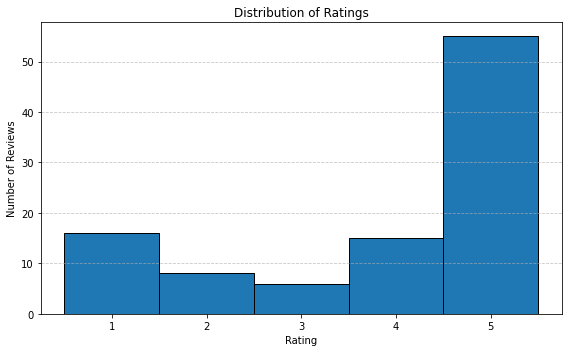

In [ ]:
ratings = []
file = output_file
with open(file, 'r') as fp:
    for i, line in enumerate(fp):
        review = json.loads(line.strip())
        rating = review.get('rating')
        if rating is not None:
            ratings.append(rating)

plt.figure(figsize=(8, 5))
plt.hist(ratings, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black', align='mid')
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Ratings')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Prepare for manual annotation
Opens the pre-selected JSON again and, for each review, builds a simplified dictionary containing an incremental ID, rating, title, and text (with an empty “Annotation” field) and prints it, preparing the rows for manual entry.

In [ ]:
file = 'data/long_reviews_sample.jsonl'

with open(file, 'r') as fp:
    for i, line in enumerate(fp):
        review = json.loads(line.strip())
        simplified = {
            'ID': i + 1,  # incrementing ID starting from 1
            'Rating': review.get('rating'),
            'Title': review.get('title'),
            'Text': review.get('text'),
            'Annotation': {},
        }
        print(json.dumps(simplified, indent=2))

## Plot code distribution
Defines two helper functions: load_json_array (to read a JSON array from disk) and count_annotation_codes (to sum up the T1–T7 tags), then loads the completed annotations file, counts each code, and displays the results as a bar chart.

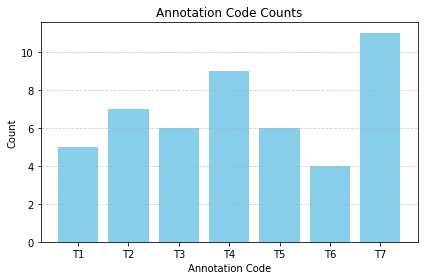

In [5]:
def load_json_array(file_path):
    """
    Load JSON data from file (valid JSON array).
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def count_annotation_codes(data):
    """
    Count annotation codes T1-T7 (supporting multiple of the same tag).
    """
    code_counter = Counter()
    valid_tags = {f"T{i}" for i in range(1, 8)}

    for entry in data:
        annotations = entry.get("Annotation", [])
        for ann in annotations:
            for tag in ann:
                if tag in valid_tags:
                    code_counter[tag] += 1
    return code_counter

def plot_counts(counts):
    """
    Plot annotation code counts.
    """
    all_tags = [f"T{i}" for i in range(1, 8)]
    values = [counts.get(tag, 0) for tag in all_tags]

    plt.bar(all_tags, values, color='skyblue')
    plt.title("Annotation Code Counts")
    plt.xlabel("Annotation Code")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

file_path = "/Users/daniel/Desktop/Scriptie/data/reviews_annotated.json" 
data = load_json_array(file_path)

counts = count_annotation_codes(data)
plot_counts(counts)

## One-shot vs. Zero-shot
Checks that the manual annotations file exists (raising an error if not) and then loads the manual data plus the model’s predictions using the two techniques (zero-shot, one-shot) into memory. A DataFrame is constructed showing the metrics per technique, and per code.

In [65]:
# check if manual annotation file exists
if not os.path.exists(manual_path):
    raise FileNotFoundError(
        f"Manual annotation file not found at: {manual_path}. "
        f"Please upload it or update 'manual_path' to the correct location."
    )

# load all JSON files
with open(manual_path, 'r') as f:
    manual_data = json.load(f)

with open(one_shot_path, 'r') as f:
    oneshot_data = json.load(f)

with open(zero_shot_path, 'r') as f:
    zeroshot_data = json.load(f)

def flatten_annotations(json_list):
    """
    Helper to convert JSON entries into a DataFrame of (ID, Code, Sentence) rows.
    """
    rows = []
    for entry in json_list:
        review_id = entry['ID']
        for annotation in entry['Annotation']:
            code = list(annotation.keys())[0]
            sent = annotation[code].strip()
            rows.append((review_id, code, sent))
    return pd.DataFrame(rows, columns=['ID', 'Code', 'Sentence'])

# build DataFrames
manual_df = flatten_annotations(manual_data)
oneshot_df = flatten_annotations(oneshot_data)
zeroshot_df = flatten_annotations(zeroshot_data)

def compute_metrics(pred_df, manual_df, method_name):
    """
    Compute TP, FP, FN and precision/recall/F1 per code, as well as macro and micro metrics.
    """
    # merge on ID, Code, Sentence to tag true positives
    merged = pd.merge(
        pred_df.assign(IsPred=True),
        manual_df.assign(IsManual=True),
        on=['ID','Code','Sentence'],
        how='outer'
    ).fillna({'IsPred': False, 'IsManual': False})

    # overall TP, FP, FN
    tp = merged[(merged['IsPred']) & (merged['IsManual'])].shape[0]
    fp = merged[(merged['IsPred']) & (~merged['IsManual'])].shape[0]
    fn = merged[(~merged['IsPred']) & (merged['IsManual'])].shape[0]
    
    # per-code metrics
    codes = sorted(manual_df['Code'].unique())
    rows = []
    for c in codes:
        tp_c = merged[(merged['Code'] == c) & (merged['IsPred']) & (merged['IsManual'])].shape[0]
        fp_c = merged[(merged['Code'] == c) & (merged['IsPred']) & (~merged['IsManual'])].shape[0]
        fn_c = merged[(merged['Code'] == c) & (~merged['IsPred']) & (merged['IsManual'])].shape[0]
        
        prec_c = tp_c / (tp_c + fp_c) if (tp_c + fp_c) > 0 else 0.0
        rec_c = tp_c / (tp_c + fn_c) if (tp_c + fn_c) > 0 else 0.0
        f1_c = (2 * prec_c * rec_c / (prec_c + rec_c)) if (prec_c + rec_c) > 0 else 0.0
        
        rows.append({
            'Code': c,
            'TP': tp_c,
            'FP': fp_c,
            'FN': fn_c,
            'Precision': round(prec_c, 3),
            'Recall': round(rec_c, 3),
            'F1': round(f1_c, 3),
        })
    
    per_code_df = pd.DataFrame(rows)
    macro_f1 = per_code_df['F1'].mean()

    # micro-average treating each row as one instance
    micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(
        merged['IsManual'], merged['IsPred'], average='binary'
    )
    
    summary = {
        'Method': method_name,
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'Macro_F1': round(macro_f1, 3),
        'Micro_Precision': round(micro_precision, 3),
        'Micro_Recall': round(micro_recall, 3),
        'Micro_F1': round(micro_f1, 3)
    }
    
    return summary, per_code_df

# compute metrics for one-shot and zero-shot
one_summary, one_per_code = compute_metrics(oneshot_df, manual_df, 'One-shot')
zero_summary, zero_per_code = compute_metrics(zeroshot_df, manual_df, 'Zero-shot')

# combine summaries into a DataFrame
summary_df = pd.DataFrame([one_summary, zero_summary])

# print results
print("=== Overall Metrics for One-shot vs Zero-shot ===")
print(summary_df.to_string(index=False))

print("\n=== Per-code Metrics (One-shot) ===")
print(one_per_code.to_string(index=False))

print("\n=== Per-code Metrics (Zero-shot) ===")
print(zero_per_code.to_string(index=False))

=== Overall Metrics for One-shot vs Zero-shot ===
   Method  TP  FP  FN  Macro_F1  Micro_Precision  Micro_Recall  Micro_F1
 One-shot  12 114  36     0.115            0.095         0.250     0.138
Zero-shot  10  79  38     0.204            0.112         0.208     0.146

=== Per-code Metrics (One-shot) ===
Code  TP  FP  FN  Precision  Recall    F1
  T1   4  51   1      0.073   0.800 0.133
  T2   2  19   5      0.095   0.286 0.143
  T3   2  13   4      0.133   0.333 0.190
  T4   0   1   9      0.000   0.000 0.000
  T5   0   0   6      0.000   0.000 0.000
  T6   1  21   3      0.045   0.250 0.077
  T7   3   9   8      0.250   0.273 0.261

=== Per-code Metrics (Zero-shot) ===
Code  TP  FP  FN  Precision  Recall    F1
  T1   2   0   3      1.000   0.400 0.571
  T2   4   8   3      0.333   0.571 0.421
  T3   1   6   5      0.143   0.167 0.154
  T4   0   3   9      0.000   0.000 0.000
  T5   1   2   5      0.333   0.167 0.222
  T6   0  10   4      0.000   0.000 0.000
  T7   2  50   9      0.03

## Compute performance metrics
Uses extract_triples to build manual and predicted triple sets for the model given in pred_data. Computes detection by precision, recall and F1. Computes classification by accuracy. A confusion matrix is created to visualize the classification errors. This is later visualized per model.

In [7]:
# load manual and predicted data, ensure to select correct model path
manual_data = json.load(open(manual_path))
pred_data = json.load(open(claude_path))

def extract_triples(data):
    """
    Given a list of {"ID":…, "Annotation":[{code: sentence, …}, …]}, 
    return a set of (ID, sentence, code) triples.
    """
    triples = set()
    for entry in data:
        review_id = entry["ID"]
        for ann in entry["Annotation"]:
            for code, sentence in ann.items():
                # normalize sentence (strip, collapse spaces)
                triples.add((review_id, sentence.strip(), code))
    return triples

# manual vs. predicted sets
M = extract_triples(manual_data)
P = extract_triples(pred_data)

# True/False Positives & Negatives on (ID, sentence, code)
TP = M & P
FP = P - M
FN = M - P

# detection (span‐only) sets: ignore code
M_spans = {(i, s) for (i, s, _) in M}
P_spans = {(i, s) for (i, s, _) in P}
TP_spans = M_spans & P_spans
FP_spans = P_spans - M_spans
FN_spans = M_spans - P_spans

# detection metrics
prec_det = len(TP_spans) / (len(TP_spans) + len(FP_spans)) if TP_spans or FP_spans else 0
rec_det  = len(TP_spans) / (len(TP_spans) + len(FN_spans)) if TP_spans or FN_spans else 0
f1_det   = (2 * prec_det * rec_det / (prec_det + rec_det)) if (prec_det + rec_det) else 0

# classification on matched sentences
# build maps from (ID, sentence) to code
manual_map = {}
pred_map = {}
for (i, s, c) in M:
    manual_map.setdefault((i, s), []).append(c)
for (i, s, c) in P:
    pred_map.setdefault((i, s), []).append(c)

# for each correctly detected span, compare all manual vs. pred codes
correct_labels = 0
total_matched = 0
confusion = Counter()
for span in TP_spans:
    manual_codes = manual_map.get(span, [])
    pred_codes = pred_map.get(span, [])
    # data often has exactly one code predicted per span,
    # loop over all combinations to be safe.
    for m in manual_codes:
        for p in pred_codes:
            total_matched += 1
            if m == p:
                correct_labels += 1
            confusion[(m, p)] += 1

acc_class = correct_labels / total_matched if total_matched else 0

# build dataframe
labels = sorted({m for (m, p) in confusion.keys()} | {p for (m, p) in confusion.keys()})
cm = pd.DataFrame(0, index=labels, columns=labels)
for (m, p), cnt in confusion.items():
    cm.at[m, p] = cnt

# print results
print("Model: Claude")
print(f"Detection: P={prec_det:.2f}, R={rec_det:.2f}, F1={f1_det:.2f}")
print(f"Classification accuracy (on matched spans): {acc_class:.2f} \n")
print("=== Confusion matrix (manual→pred) === ")
print(cm)

Model: Claude
Detection: P=0.30, R=0.58, F1=0.40
Classification accuracy (on matched spans): 0.36 

=== Confusion matrix (manual→pred) === 
    T1  T2  T3  T4  T5  T7
T1   2   2   0   0   0   0
T2   0   2   1   0   1   0
T3   0   0   5   0   0   0
T4   0   2   0   1   0   0
T5   0   3   0   0   0   1
T7   1   5   2   0   0   0


## Create matrices
Uses a new helper function (compute_cm) to create the matrices for each model, to construct a dictionary with the model name as key, and cm as value.

In [8]:
# full set of labels
ALL_LABELS = ["T1", "T2", "T3", "T4", "T5", "T6", "T7"]

def compute_cm(pred_path, manual_spans, manual_map):
    P = extract_triples(json.load(open(pred_path)))
    P_spans = {(i, s) for (i, s, _) in P}
    TP_spans = manual_spans & P_spans

    # build pred_map
    pred_map = {}
    for (i, s, c) in P:
        pred_map.setdefault((i, s), []).append(c)

    # confusion counts
    confusion = Counter()
    for span in TP_spans:
        for m in manual_map.get(span, []):
            for p in pred_map.get(span, []):
                confusion[(m, p)] += 1

    # turn into a DataFrame
    labels = sorted({m for (m, p) in confusion} | {p for (m, p) in confusion})
    cm = pd.DataFrame(0, index=labels, columns=labels)
    for (m, p), cnt in confusion.items():
        cm.at[m, p] = cnt

    # ensure all T1–T7 appear, filling missing with 0
    cm = cm.reindex(index=ALL_LABELS, columns=ALL_LABELS, fill_value=0)
    return cm

# precompute manual spans & label‐map
manual_data = json.load(open(manual_path))
M = extract_triples(manual_data)
M_spans  = {(i, s) for (i, s, _) in M}
manual_map = {}
for (i, s, c) in M:
    manual_map.setdefault((i, s), []).append(c)

# compute one cm per model
models = {
    'GPT-o3'       : GPT_o3_path,
    'GPT-4o'       : GPT_4o_path,
    'GPT-o4-mini'  : GPT_o4_mini_path,
    'Gemini-2.5pro': gemini_path,
    'Claude-sonnet4': claude_path
}
cms = {name: compute_cm(path, M_spans, manual_map) for name, path in models.items()}


## Visualize classification errors
Uses the cms to generate heatmaps of the different models’ classification errors.

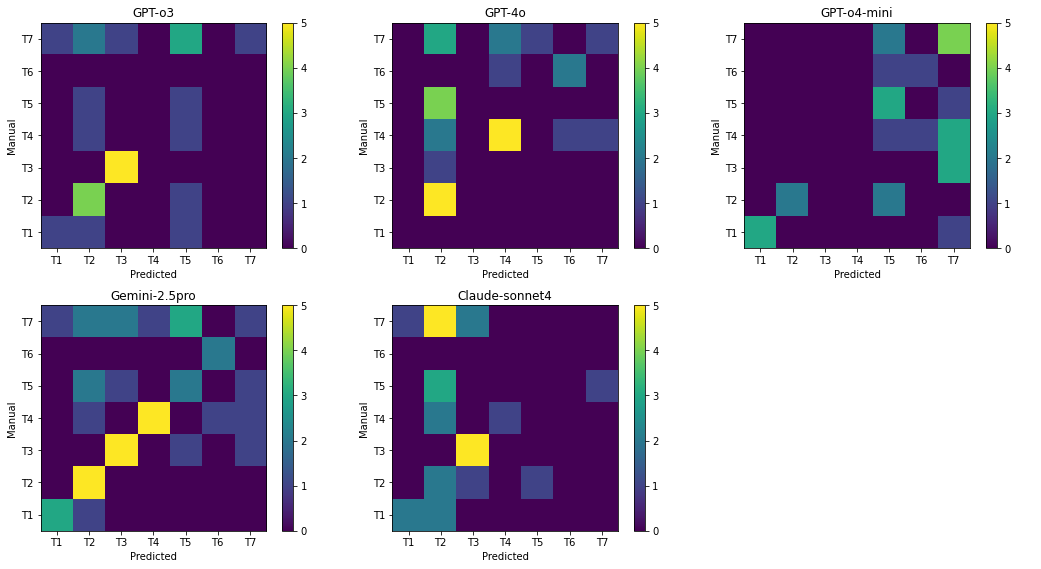

In [63]:
max_val = max(df.values.max() for df in cms.values())

model_names = list(cms.keys())

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,8))

for ax, model_name in zip(axes.flat, model_names):
    cm_df = cms[model_name]
    im = ax.imshow(cm_df.values, aspect='equal', origin='lower', vmin=0, vmax=max_val)
    ax.set_xticks(range(len(cm_df.columns)))
    ax.set_xticklabels(cm_df.columns)
    ax.set_yticks(range(len(cm_df.index)))
    ax.set_yticklabels(cm_df.index)
    ax.set_title(model_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Manual')
    fig.colorbar(im, ax=ax)

# Turn off any unused subplots
for ax in axes.flat[n_models:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
